# Import Packages

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Hyperparameters
BATCH_SIZE = 64
NUM_LABELS = 7
EPOCHS = 30
WIDTH, HEIGHT = 48, 48
LR = 0.0001
WEIGHT_DECAY = 1e-6
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Dataset and Applying Transforms on it

In [3]:
# Transformation
myTransform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Grayscale(),   # Convert to grayscale
    transforms.Normalize((0.5,), (0.5,))  
])

In [4]:
train_dataset = ImageFolder(root = './data/train', transform= myTransform)
test_dataset = ImageFolder(root= './data/test', transform= myTransform)

In [5]:
train_dataset.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [6]:
len(train_dataset)

28709

In [7]:
index_to_class_dict = {value: key for key, value in train_dataset.class_to_idx.items()}
index_to_class_dict

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

## Plotting Distribution of Data Over Various Categories 

In [8]:
# Calculate class counts
class_counts = torch.zeros(len(train_dataset.classes), dtype=torch.int64)
for _, label in train_dataset:
    class_counts[label] += 1

# Normalize counts
total_images = len(train_dataset)
class_percentages = 100 * class_counts / total_images

In [9]:
class_counts.shape

torch.Size([7])

In [10]:
classes = train_dataset.classes
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

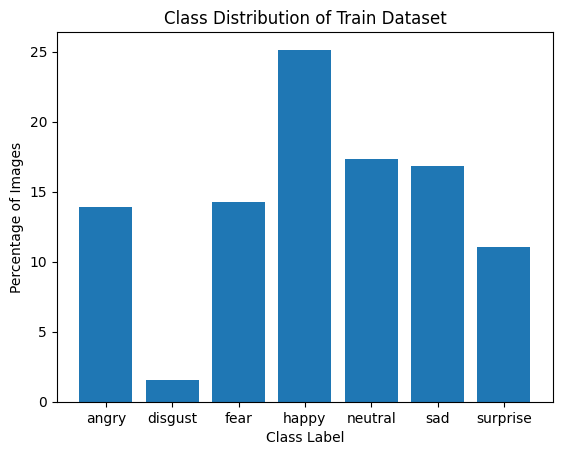

In [11]:
plt.bar(train_dataset.classes, class_percentages)
plt.xlabel("Class Label")
plt.ylabel("Percentage of Images")
plt.title(f"Class Distribution of Train Dataset")
plt.show()

## Splitting Dataset

In [12]:
#Split train_dataset to train and val sets 90/10

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, (train_size, val_size))

In [13]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle= False)
test_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= False)

In [14]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

25838
2871
7178


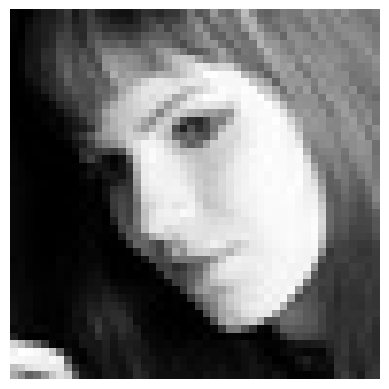

sad


In [15]:
# Show sample from dataset
sample_image, sample_label = next(iter(train_loader))
for i in range(BATCH_SIZE):
    plt.imshow(sample_image[i].numpy().transpose((1, 2, 0)), cmap='gray') # Set the third dimension as the channel size
    plt.axis('off')
    plt.show()
    print(index_to_class_dict[int(sample_label[i])])
    break

# Model

In [16]:
class fourLayerRecognition(nn.Module):
    def __init__(self, num_labels):
        super (fourLayerRecognition, self).__init__()

        self.num_labels = num_labels

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels= 1, out_channels= 64, kernel_size= 3, padding= "same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2, stride= 2),
            nn.Dropout(0.25)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= 3, padding= 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2, stride= 2),
            nn.Dropout(0.25)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size=3 , padding= 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2, stride= 2),
            nn.Dropout(0.25)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels= 256, out_channels= 512, kernel_size=3 , padding= 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2, stride= 2),
            nn.Dropout(0.25)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features= 512*3*3, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.output = nn.Sequential(
            nn.Linear(1024, num_labels)
        ) 
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.output(x)

        output = nn.functional.softmax(x, dim=1)
        return output
        
model = fourLayerRecognition(NUM_LABELS).to(DEVICE)

# Training

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR, weight_decay= WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for i, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        train_loss += loss.item() * data.size(0)
        train_acc += ((predicted == label).sum().item())

    train_loss_history.append(train_loss / len(train_loader.dataset))
    train_acc_history.append(train_acc / len(train_loader.dataset))

    val_loss, val_acc = 0.0, 0.0
    model.eval()
    for i, (data, label) in enumerate(val_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)
        outputs = model(data)
        loss = loss_func(outputs, label)

        _, predicted = torch.max(outputs.data, 1)
        val_loss += loss.item() * data.size(0)
        val_acc += ((predicted == label).sum().item())

    val_loss_history.append(val_loss / len(val_loader.dataset))
    val_acc_history.append(val_acc / len(val_loader.dataset))


    # Print epoch summary
    print(f"Train Loss: {train_loss / len(train_loader.dataset):.4f}, Train Acc: {train_acc / len(train_loader.dataset):.4f}")
    print(f"Val Loss: {val_loss / len(val_loader.dataset):.4f}, Val Acc: {val_acc / len(val_loader.dataset):.4f}")


torch.save(model.state_dict(), "FER_model.pt")
np.save("train_loss_history.npy", train_loss_history)
np.save("train_acc_history.npy", train_acc_history)
np.save("val_loss_history.npy", val_loss_history)
np.save("val_acc_history.npy", val_acc_history)

Epoch 1/30
Train Loss: 1.8498, Train Acc: 0.2994
Val Loss: 1.7861, Val Acc: 0.3612
Epoch 2/30
Train Loss: 1.7597, Train Acc: 0.3952
Val Loss: 1.7250, Val Acc: 0.4288
Epoch 3/30
Train Loss: 1.7231, Train Acc: 0.4356
Val Loss: 1.7101, Val Acc: 0.4417
Epoch 4/30
Train Loss: 1.6999, Train Acc: 0.4576
Val Loss: 1.6950, Val Acc: 0.4591
Epoch 5/30
Train Loss: 1.6826, Train Acc: 0.4743
Val Loss: 1.6675, Val Acc: 0.4883
Epoch 6/30
Train Loss: 1.6663, Train Acc: 0.4931
Val Loss: 1.6516, Val Acc: 0.5040
Epoch 7/30
Train Loss: 1.6528, Train Acc: 0.5074
Val Loss: 1.6293, Val Acc: 0.5336
Epoch 8/30
Train Loss: 1.6397, Train Acc: 0.5216
Val Loss: 1.6288, Val Acc: 0.5284
Epoch 9/30
Train Loss: 1.6283, Train Acc: 0.5322
Val Loss: 1.6271, Val Acc: 0.5305
Epoch 10/30
Train Loss: 1.6208, Train Acc: 0.5386
Val Loss: 1.6153, Val Acc: 0.5451
Epoch 11/30
Train Loss: 1.6154, Train Acc: 0.5447
Val Loss: 1.6119, Val Acc: 0.5455
Epoch 12/30
Train Loss: 1.6053, Train Acc: 0.5569
Val Loss: 1.6013, Val Acc: 0.5608
E

# TEST

In [18]:
test_acc = 0.0
test_labels = []
test_predictions = []

with torch.no_grad():
    for i, (data, label) in enumerate(test_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)
        outputs = model(data)
        loss = loss_func(outputs, label)

        _, predicted = torch.max(outputs.data, 1)
        test_labels.extend(label.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

correct = np.sum(np.array(test_labels) == np.array(test_predictions))
test_accuracy = correct / len(test_labels)
print(f"Test Accuracy: {test_accuracy}")

np.save("test_labels.npy", test_labels)
np.save("test_predictions.npy", test_predictions)

Test Accuracy: 0.5823349122318194


# Plotting Results

### Confusion Matrix

In [19]:
test_cm = confusion_matrix(test_labels, test_predictions)
row_sums = test_cm.sum(axis=1, keepdims=True)
normalized_conf_matrix = test_cm / row_sums

np.save("test_confusion_matrix.npy", normalized_conf_matrix)

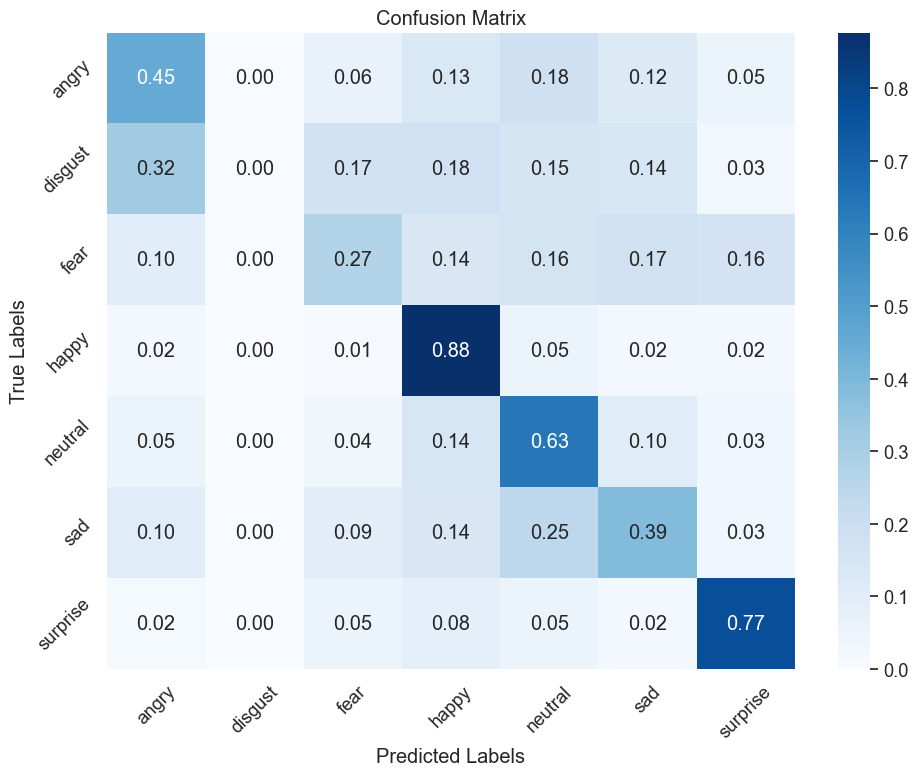

In [20]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(normalized_conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels= classes, yticklabels= classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("confusion_matrix_heatmap.png")
plt.show()

### Curves

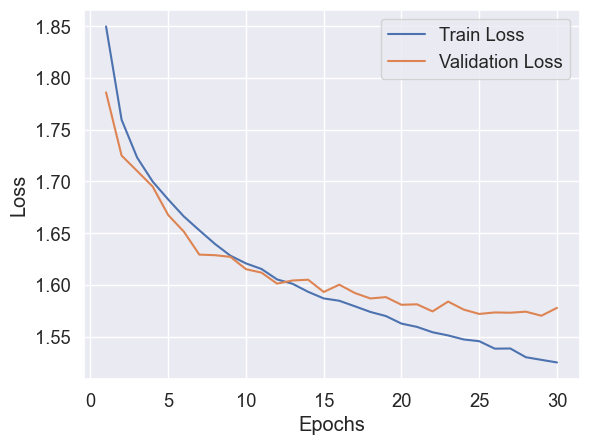

In [21]:
# Plot training and validation loss curves
plt.figure()
plt.plot(range(1, EPOCHS + 1), train_loss_history, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_curve.png")

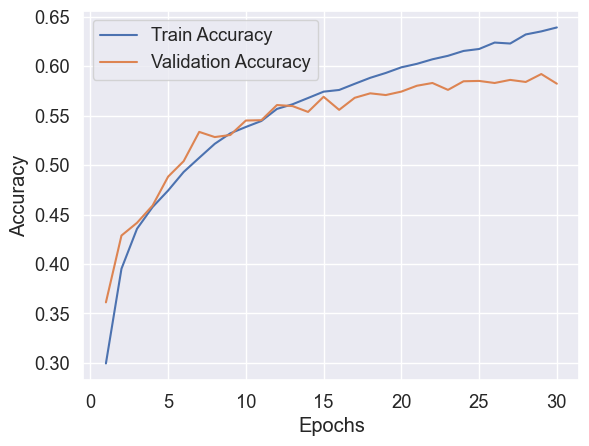

In [22]:
# Plot training and validation accuracy curves
plt.figure()
plt.plot(range(1, EPOCHS + 1), train_acc_history, label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_curve.png")